In [1]:
!wget direct-file-upload.hostfl.ru/files/vlcs.tar.gz

--2024-04-20 03:49:21--  http://direct-file-upload.hostfl.ru/files/vlcs.tar.gz
Resolving direct-file-upload.hostfl.ru (direct-file-upload.hostfl.ru)... 178.208.86.166
Connecting to direct-file-upload.hostfl.ru (direct-file-upload.hostfl.ru)|178.208.86.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201475153 (192M) [application/octet-stream]
Saving to: ‘vlcs.tar.gz’

vlcs.tar.gz         100%[===================>] 192.14M  14.4MB/s    in 14s     

2024-04-20 03:49:36 (13.7 MB/s) - ‘vlcs.tar.gz’ saved [201475153/201475153]



In [ ]:
!tar -xvzf vlcs.tar.gz

In [3]:
import tensorflow as tf
import numpy as np
import os

In [19]:
class DataLoader:
    def __init__(self, dataset_type='train', dataset_dir = "./VLCS/CALTECH",):
        self.dataset_dir = dataset_dir
        self.dataset_type = dataset_type
        self.classes = os.listdir(os.path.join(dataset_dir, self.dataset_type))
        self.images, self.labels = self.load_data()

    def load_data(self):
        images = []
        labels = []
        data_dir = os.path.join(self.dataset_dir, self.dataset_type)
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = tf.io.read_file(image_path)
                image = tf.image.decode_image(image, channels=3)
                # Resize image if necessary
                image = tf.image.resize(image, [224, 224])
                image = tf.cast(image, tf.float32) / 255.0  # Normalize
                images.append(image)
                labels.append(int(class_name))
        return images, labels

    def __call__(self):
        for image, label in zip(self.images, self.labels):
            yield image, label

In [20]:
dataset_dir = './VLCS/CALTECH'

In [21]:
train_loader = DataLoader('train', dataset_dir)

train_dataset = tf.data.Dataset.from_generator(train_loader,
                                               output_types=(tf.float32, tf.int32),
                                               output_shapes=([224, 224, 3], ()))

train_batches = train_dataset.batch(16)

In [22]:
valid_loader = DataLoader('crossval', dataset_dir)

valid_dataset = tf.data.Dataset.from_generator(valid_loader,
                                              output_types=(tf.float32, tf.int32),
                                              output_shapes=([224, 224, 3], ()))
valid_batches = valid_dataset.batch(16)

In [23]:
test_loader = DataLoader('test', dataset_dir)

test_dataset = tf.data.Dataset.from_generator(test_loader,
                                              output_types=(tf.float32, tf.int32),
                                              output_shapes=([224, 224, 3], ()))
test_batches = test_dataset.batch(16)

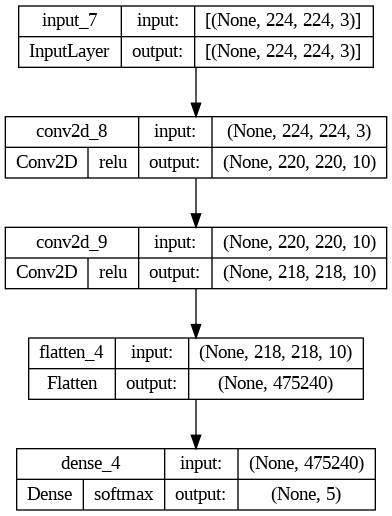

In [33]:
layer_input = tf.keras.layers.Input(shape=(224, 224, 3))
_layer = tf.keras.layers.Conv2D(10, 5, activation='relu')(layer_input)
_layer = tf.keras.layers.Conv2D(10, 3, activation='relu')(_layer)
_layer = tf.keras.layers.Flatten()(_layer)
_layer = tf.keras.layers.Dense(5, activation='softmax')(_layer)
model = tf.keras.models.Model(inputs=layer_input, outputs=_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [29]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  mode='max', patience=3)

In [34]:
model.fit(train_batches, epochs=100, validation_data=valid_batches, callbacks=[early_stopping_callback])

Epoch 1/100
56/56 [==============================] - 42s 747ms/step - loss: 19.0227 - accuracy: 0.7093 - val_loss: 1.6748 - val_accuracy: 0.5700
Epoch 2/100
56/56 [==============================] - 40s 719ms/step - loss: 2.9925 - accuracy: 0.3883 - val_loss: 1.4430 - val_accuracy: 0.6100
Epoch 3/100
56/56 [==============================] - 40s 712ms/step - loss: 1.5203 - accuracy: 0.5769 - val_loss: 1.5128 - val_accuracy: 0.6100
Epoch 4/100
56/56 [==============================] - 42s 743ms/step - loss: 1.2690 - accuracy: 0.6431 - val_loss: 1.4826 - val_accuracy: 0.6400
Epoch 5/100
56/56 [==============================] - 40s 716ms/step - loss: 3.2837 - accuracy: 0.6274 - val_loss: 1.3844 - val_accuracy: 0.6400
Epoch 6/100
56/56 [==============================] - 42s 745ms/step - loss: 1.1290 - accuracy: 0.6655 - val_loss: 1.2217 - val_accuracy: 0.6100
Epoch 7/100
56/56 [==============================] - 40s 711ms/step - loss: 0.8655 - accuracy: 0.7037 - val_loss: 1.2573 - val_accuracy

In [35]:
model.evaluate(test_batches)

27/27 [==============================] - 6s 228ms/step - loss: 1.3829 - accuracy: 0.6250


[1.3828941583633423, 0.625]

In [36]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
